<a href="https://colab.research.google.com/github/Kendal12/Python/blob/master/hdfs_GLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1
  

     |████████████████████████████████| 440kB 13.5MB/s 
     |████████████████████████████████| 235kB 25.0MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 


In [3]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [4]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from tensorflow import keras

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder
from stellargraph.data import UnsupervisedSampler

import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from stellargraph.layer import GCN_LSTM

%matplotlib inline

In [5]:
#dataset = sg.datasets.METR_LA()

#speed_data, sensor_dist_adj = dataset.load()
#num_nodes, time_len = speed_data.shape
#print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

In [6]:
hdfs_feature_names = [f"w{i}" for i in range(6)]

hdfs_data = pd.read_csv(
    "HDFS_2k_duzeltilmis.csv",
    sep=",",  # tab-separated
    #header=int,  # no heading row
    #names=["source","target",*hdfs_feature_names, "subject"],  # set our own names for the columns
)

hdfs_data

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,E10,PacketResponder <*> for block blk_<*> terminating
1,2,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,E10,PacketResponder <*> for block blk_<*> terminating
2,3,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E6,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,4,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,E10,PacketResponder <*> for block blk_<*> terminating
4,5,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,E10,PacketResponder <*> for block blk_<*> terminating
...,...,...,...,...,...,...,...,...,...
1995,1996,81111,101621,24902,INFO,dfs.DataNode$DataXceiver,Receiving block blk_4198733391373026104 src: /...,E13,Receiving block blk_<*> src: /<*>:<*> dest: /<...
1996,1997,81111,101735,26595,INFO,dfs.DataNode$PacketResponder,Received block blk_-5815145248455404269 of siz...,E11,Received block blk_<*> of size <*> from /<*>
1997,1998,81111,101804,26494,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-295306975763175640 src: /...,E13,Receiving block blk_<*> src: /<*>:<*> dest: /<...
1998,1999,81111,101954,26414,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_52257196770490...,E10,PacketResponder <*> for block blk_<*> terminating


In [7]:
hdfs_data=hdfs_data.drop(columns=[  "Date","Time","Level","Pid","Component","Content"])
le = LabelEncoder()
hdfs_data["source"]=le.fit_transform(hdfs_data["EventId"])
hdfs_data["target"]=le.fit_transform(hdfs_data["EventTemplate"])

hdfs_data

,LineId,EventId,EventTemplate,source,target
0,1,E10,PacketResponder <*> for block blk_<*> terminating,1,9
1,2,E10,PacketResponder <*> for block blk_<*> terminating,1,9
2,3,E6,BLOCK* NameSystem.addStoredBlock: blockMap upd...,10,3
3,4,E10,PacketResponder <*> for block blk_<*> terminating,1,9
4,5,E10,PacketResponder <*> for block blk_<*> terminating,1,9
...,...,...,...,...,...
1995,1996,E13,Receiving block blk_<*> src: /<*>:<*> dest: /<...,4,12
1996,1997,E11,Received block blk_<*> of size <*> from /<*>,2,10
1997,1998,E13,Receiving block blk_<*> src: /<*>:<*> dest: /<...,4,12
1998,1999,E10,PacketResponder <*> for block blk_<*> terminating,1,9


In [8]:


hdfs_data_edges=hdfs_data.drop(columns=[ "LineId","EventId", "EventTemplate"])
hdfs_data_edges



,source,target
0,1,9
1,1,9
2,10,3
3,1,9
4,1,9
...,...,...
1995,4,12
1996,2,10
1997,4,12
1998,1,9


In [9]:
hdfs_data_node = pd.read_csv(
    "HDFS_2k_duzeltilmis.csv",
    sep=",",  # tab-separated
    #header=None,  # no heading row
    #names=[*nslkdd_data_feature_names, "subject"],  # set our own names for the columns
)
hdfs_data_node

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,E10,PacketResponder <*> for block blk_<*> terminating
1,2,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,E10,PacketResponder <*> for block blk_<*> terminating
2,3,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,E6,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,4,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,E10,PacketResponder <*> for block blk_<*> terminating
4,5,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,E10,PacketResponder <*> for block blk_<*> terminating
...,...,...,...,...,...,...,...,...,...
1995,1996,81111,101621,24902,INFO,dfs.DataNode$DataXceiver,Receiving block blk_4198733391373026104 src: /...,E13,Receiving block blk_<*> src: /<*>:<*> dest: /<...
1996,1997,81111,101735,26595,INFO,dfs.DataNode$PacketResponder,Received block blk_-5815145248455404269 of siz...,E11,Received block blk_<*> of size <*> from /<*>
1997,1998,81111,101804,26494,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-295306975763175640 src: /...,E13,Receiving block blk_<*> src: /<*>:<*> dest: /<...
1998,1999,81111,101954,26414,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_52257196770490...,E10,PacketResponder <*> for block blk_<*> terminating


In [10]:
hdfs_data_node=hdfs_data_node.drop(columns=["LineId","EventTemplate","EventId"])
hdfs_data_node

,Date,Time,Pid,Level,Component,Content
0,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...
1,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...
2,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...
4,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...
...,...,...,...,...,...,...
1995,81111,101621,24902,INFO,dfs.DataNode$DataXceiver,Receiving block blk_4198733391373026104 src: /...
1996,81111,101735,26595,INFO,dfs.DataNode$PacketResponder,Received block blk_-5815145248455404269 of siz...
1997,81111,101804,26494,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-295306975763175640 src: /...
1998,81111,101954,26414,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_52257196770490...


In [11]:
hdfs_data_node = pd.get_dummies(
    hdfs_data_node, columns=["Level","Component","Content"]
)
hdfs_data_node

,Date,Time,Pid,Level_INFO,Level_WARN,Component_dfs.DataBlockScanner,Component_dfs.DataNode,Component_dfs.DataNode$DataXceiver,Component_dfs.DataNode$PacketResponder,Component_dfs.FSDataset,Component_dfs.FSNamesystem,Content_10.250.10.100:50010 Served block blk_-3657665801189425193 to /10.250.10.100,Content_10.250.10.100:50010 Served block blk_9216955386716663841 to /10.251.90.64,Content_10.250.10.144:50010:Got exception while serving blk_5126469776250053435 to /10.250.11.100:,Content_10.250.10.176:50010 Served block blk_3797494971676497497 to /10.251.29.239,Content_10.250.10.213:50010 Served block blk_-1125621902344947014 to /10.250.10.213,Content_10.250.10.223:50010:Got exception while serving blk_8478683141242372735 to /10.251.70.5:,Content_10.250.10.223:50010:Got exception while serving blk_9095955277706686312 to /10.250.5.161:,Content_10.250.10.6:50010 Served block blk_1200136320542454615 to /10.250.10.6,Content_10.250.10.6:50010 Served block blk_1598414622053793245 to /10.251.90.239,Content_10.250.11.194:50010 Served block blk_3087787567144441647 to /10.251.91.84,Content_10.250.11.194:50010 Served block blk_8591104451552720112 to /10.250.11.194,Content_10.250.11.53:50010 Served block blk_-743349875664670637 to /10.250.11.53,Content_10.250.11.53:50010:Got exception while serving blk_-7125370327234065733 to /10.250.15.240:,Content_10.250.13.188:50010:Got exception while serving blk_6241141267506413726 to /10.251.194.245:,Content_10.250.13.188:50010:Got exception while serving blk_73389299186801686 to /10.251.123.33:,Content_10.250.13.240:50010 Served block blk_-3134225108208373949 to /10.250.13.240,Content_10.250.14.143:50010 Served block blk_-664656559337730574 to /10.250.7.96,Content_10.250.14.196:50010:Got exception while serving blk_-305633040016166849 to /10.251.38.53:,Content_10.250.14.196:50010:Got exception while serving blk_2967299761311489673 to /10.251.89.155:,Content_10.250.14.224:50010 Served block blk_666713934549639791 to /10.250.14.224,Content_10.250.14.38:50010 Served block blk_-8674089929114017279 to /10.250.14.38,Content_10.250.15.101:50010 Served block blk_-2557432794238860908 to /10.251.74.134,Content_10.250.15.198:50010 Starting thread to transfer block blk_4292382298896622412 to 10.250.15.240:50010,Content_10.250.15.198:50010:Got exception while serving blk_-1851265222873801714 to /10.251.195.52:,Content_10.250.17.225:50010 Served block blk_-2656323385657954732 to /10.250.17.225,Content_10.250.17.225:50010:Got exception while serving blk_-5935642747315643391 to /10.251.199.150:,Content_10.250.19.16:50010 Served block blk_-7837339190764609698 to /10.251.197.161,Content_10.250.19.16:50010 Served block blk_1078000656626961731 to /10.250.19.16,Content_10.250.19.227:50010 Served block blk_3979872751691718643 to /10.250.19.227,...,Content_Receiving block blk_8235751201501175836 src: /10.250.11.194:37449 dest: /10.250.11.194:50010,Content_Receiving block blk_8303284829424905326 src: /10.251.70.37:47359 dest: /10.251.70.37:50010,Content_Receiving block blk_8452214765874767801 src: /10.251.38.197:60409 dest: /10.251.38.197:50010,Content_Receiving block blk_8473858691873523269 src: /10.250.11.53:60609 dest: /10.250.11.53:50010,Content_Receiving block blk_8574493302165689212 src: /10.251.194.245:34656 dest: /10.251.194.245:50010,Content_Receiving block blk_8596624696139957935 src: /10.251.214.175:41468 dest: /10.251.214.175:50010,Content_Receiving block blk_8692428775973608797 src: /10.250.10.213:56574 dest: /10.250.10.213:50010,Content_Receiving block blk_8752665860595246441 src: /10.251.70.5:44006 dest: /10.251.70.5:50010,Content_Receiving block blk_8907528844412790999 src: /10.251.126.227:42572 dest: /10.251.126.227:50010,Content_Receiving block blk_8942969309743886844 src: /10.251.110.68:58266 dest: /10.251.110.68:50010,Content_Receiving block blk_8992894896370738220 src: /10.251.43.210:54766 dest: /10.251.43.210:50010,Content_Receiving block blk_9034824096129858680 src: /10.250.6.223:45371 dest: /10.250.6.2

In [12]:
G = StellarGraph(
    {"node":hdfs_data_node},  {"edges":hdfs_data_edges }
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2000, Edges: 2000

 Node types:
  node: [2000]
    Features: float32 vector, length 2011
    Edge types: node-edges->node

 Edge types:
    node-edges->node: [2000]
        Weights: all 1 (default)
        Features: none


In [13]:
walk_number = 100
walk_length = 5

In [14]:
walker = BiasedRandomWalk(
    G,
    n=walk_number,
    length=walk_length,
    p=0.5,  # defines probability, 1/p, of returning to source node
    q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
)

In [15]:
unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)

In [16]:
batch_size = 50
epochs = 3

In [17]:
generator = Node2VecLinkGenerator(G, batch_size)

In [18]:
emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

In [19]:
x_inp, x_out = node2vec.in_out_tensors()

In [20]:
x_inp, x_out

([<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_2')>],
 [<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'reshape')>,
  <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'reshape_1')>])

In [21]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


In [22]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/3
224/224 [==============================] - 2s 5ms/step - loss: 0.5158 - binary_accuracy: 0.7807
Epoch 2/3
224/224 [==============================] - 1s 5ms/step - loss: 0.3944 - binary_accuracy: 0.8646
Epoch 3/3
224/224 [==============================] - 1s 5ms/step - loss: 0.3443 - binary_accuracy: 0.8739


In [24]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [32]:
lineid=hdfs_data["LineId"]
target=hdfs_data["target"]

In [33]:
node_gen = Node2VecNodeGenerator(G, batch_size).flow(lineid.index)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

40/40 [==============================] - 0s 3ms/step


In [34]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

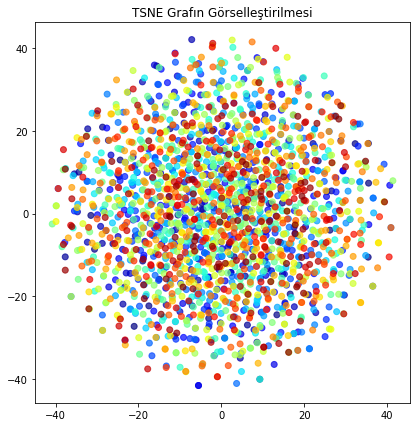

In [35]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(lineid))}
node_colours = [label_map[target] for target in lineid]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} Grafın Görselleştirilmesi".format(transform.__name__))
plt.show()

In [36]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(target)


In [37]:
y

array([ 9,  9,  3, ..., 12,  9, 12])

In [38]:
trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.3, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        trainX.shape, trainY.shape, testX.shape, testY.shape
    )
)

Array shapes:
 X_train = (600, 128)
 y_train = (600,)
 X_test = (1400, 128)
 y_test = (1400,)


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM

In [40]:
print(trainX.shape[0:])

(600, 128)


In [41]:
model = Sequential()

In [42]:
model.add(tf.keras.layers.Flatten())
model.add(LSTM(128, input_shape=(trainX.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(1, activation='softmax'))



model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [43]:
model.fit(trainX,trainY,epochs=3, validation_data=(testX,testY))

Epoch 1/3


ValueError: ignored

In [ ]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [ ]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

ValueError: ignored

In [ ]:
model.summary()